In [ ]:
import pandas as pd
import numpy as np

print("🔹 Step 1: Loading the input CSV...")
csv_path = "/kaggle/input/severityy/ensemble_individual_prediction_severity.csv"
df = pd.read_csv(csv_path)
print(f"✅ Loaded {len(df)} samples from: {csv_path}")

model_cols = [
    "bert-base-arabert-Severity_Prediction",
    "BioBERT-Severity_Prediction",
    "DistilBERT-Severity_Prediction",
    "bert-base-multilingual-cased-Severity_Prediction",
    "XLM-RoBERTa-Severity_Prediction"
]
print("\n🔹 Step 2: Model columns for voting:")
for col in model_cols:
    print(f" - {col}")

weights = {
    "bert-base-arabert-Severity_Prediction": 0.3,
    "BioBERT-Severity_Prediction": 0.25,
    "DistilBERT-Severity_Prediction": 0.15,
    "bert-base-multilingual-cased-Severity_Prediction": 0.2,
    "XLM-RoBERTa-Severity_Prediction": 0.1
}
print("\n🔹 Step 3: Using model weights:")
for k, v in weights.items():
    print(f" - {k}: {v}")

def weighted_vote(row):
    score_map = {}
    for col in model_cols:
        pred = row[col]
        weight = weights[col]
        score_map[pred] = score_map.get(pred, 0) + weight
    best = max(score_map, key=score_map.get)
    return best

print("\n🔹 Step 4: Applying weighted voting to each row...")
df["Weighted_Ensemble_Prediction"] = df.apply(weighted_vote, axis=1)

print("✅ Voting complete.")

df["Correct"] = df["Weighted_Ensemble_Prediction"] == df["True_Severity"]
accuracy = df["Correct"].mean()

output_path = "weighted_vote_results.csv"
df.to_csv(output_path, index=False)

print(f"\n📊 Step 5: Accuracy = {accuracy:.4f}")
print(f"📁 Results saved to: {output_path}")

print("\n🔹 Sample predictions:")
print(df[[
    "True_Severity",
    "Weighted_Ensemble_Prediction",
    "Correct"
] + model_cols].head())


🔹 Step 1: Loading the input CSV...
✅ Loaded 39789 samples from: /kaggle/input/severityy/ensemble_individual_prediction_severity.csv

🔹 Step 2: Model columns for voting:
 - bert-base-arabert-Severity_Prediction
 - BioBERT-Severity_Prediction
 - DistilBERT-Severity_Prediction
 - bert-base-multilingual-cased-Severity_Prediction
 - XLM-RoBERTa-Severity_Prediction

🔹 Step 3: Using model weights:
 - bert-base-arabert-Severity_Prediction: 0.3
 - BioBERT-Severity_Prediction: 0.25
 - DistilBERT-Severity_Prediction: 0.15
 - bert-base-multilingual-cased-Severity_Prediction: 0.2
 - XLM-RoBERTa-Severity_Prediction: 0.1

🔹 Step 4: Applying weighted voting to each row...
✅ Voting complete.

📊 Step 5: Accuracy = 0.9611
📁 Results saved to: weighted_vote_results.csv

🔹 Sample predictions:
  True_Severity Weighted_Ensemble_Prediction  Correct  \
0       غير حرج                      غير حرج     True   
1       غير حرج                      غير حرج     True   
2       غير حرج                      غير حرج   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import joblib

df = pd.read_csv("/kaggle/input/typeeee/ensemble_individual_prediction (2).csv")

model_cols = [
    "bert-base-arabert-Severity_Prediction",
    "BioBERT-Severity_Prediction",
    "DistilBERT-Severity_Prediction",
    "bert-base-multilingual-cased-Severity_Prediction",
    "XLM-RoBERTa-Severity_Prediction"
]

all_labels = sorted(df["True_Category"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

for col in model_cols:
    df[col + "_id"] = df[col].map(label_to_id)
df["True_Category_id"] = df["True_Category"].map(label_to_id)

X = df[[col + "_id" for col in model_cols]].values
y = df["True_Category_id"].values

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X, y)

joblib.dump(meta_model, "meta_classifier.pkl")
print("✅ Meta-classifier trained and saved as 'meta_classifier.pkl'")


KeyError: 'bert-base-arabert-Severity_Prediction'

In [ ]:
import pandas as pd
import numpy as np
import joblib

# 🔹 Paths
csv_path = "/kaggle/working/weighted_vote_results.csv"
meta_model_path = "/kaggle/working/meta_classifier.pkl"

df = pd.read_csv(csv_path)

meta_model = joblib.load(meta_model_path)

model_cols = [
    "bert-base-arabert-Severity_Prediction",
    "BioBERT-Severity_Prediction",
    "DistilBERT-Severity_Prediction",
    "bert-base-multilingual-cased-Severity_Prediction",
    "XLM-RoBERTa-Severity_Prediction"
]

all_labels = sorted(df["True_Severity"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

def extract_stacking_features(row):
    return [label_to_id[row[col]] for col in model_cols]

X_stacking = np.array(df.apply(extract_stacking_features, axis=1).tolist())

stacked_preds = meta_model.predict(X_stacking)
df["Stacking_Ensemble_Prediction"] = [id_to_label[pred] for pred in stacked_preds]
df["Stacking_Correct"] = df["Stacking_Ensemble_Prediction"] == df["True_Severity"]

df.to_csv(csv_path, index=False)

accuracy = df["Stacking_Correct"].mean()
print(f"✅ Stacking Ensemble Accuracy: {accuracy:.4f}")
print(f"📁 Results updated and saved to: {csv_path}")
print("\n🔹 Preview:")
print(df[["True_Severity", "Weighted_Ensemble_Prediction", "Stacking_Ensemble_Prediction", "Stacking_Correct"]].head())


In [ ]:
import pandas as pd
import numpy as np
import joblib

input_csv_path = "/kaggle/working/weighted_vote_results.csv"
meta_model_path = "/kaggle/working/meta_classifier.pkl"
output_csv_path = "/kaggle/working/ensemble_with_stacking_results.csv"

df = pd.read_csv(input_csv_path)

meta_model = joblib.load(meta_model_path)

model_cols = [
    "bert-base-arabert-Severity_Prediction",
    "BioBERT-Severity_Prediction",
    "DistilBERT-Severity_Prediction",
    "bert-base-multilingual-cased-Severity_Prediction",
    "XLM-RoBERTa-Severity_Prediction"
]

all_labels = sorted(df["True_Severity"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

def extract_stacking_features(row):
    return [label_to_id[row[col]] for col in model_cols]

X_stacking = np.array(df.apply(extract_stacking_features, axis=1).tolist())

=stacked_preds = meta_model.predict(X_stacking)
df["Stacking_Ensemble_Prediction"] = [id_to_label[pred] for pred in stacked_preds]
df["Stacking_Correct"] = df["Stacking_Ensemble_Prediction"] == df["True_Severity"]

df.to_csv(output_csv_path, index=False)

accuracy = df["Stacking_Correct"].mean()
print(f"✅ Stacking Ensemble Accuracy: {accuracy:.4f}")
print(f"📁 Results saved to: {output_csv_path}")
print("\n🔹 Preview:")
print(df[["True_Severity", "Weighted_Ensemble_Prediction", "Stacking_Ensemble_Prediction", "Stacking_Correct"]].head())


✅ Stacking Ensemble Accuracy: 0.9696
📁 Results saved to: /kaggle/working/ensemble_with_stacking_results.csv

🔹 Preview:
  True_Severity Weighted_Ensemble_Prediction Stacking_Ensemble_Prediction  \
0       غير حرج                      غير حرج                      غير حرج   
1       غير حرج                      غير حرج                      غير حرج   
2       غير حرج                      غير حرج                          حرج   
3           حرج                          حرج                          حرج   
4       غير حرج                      غير حرج                      غير حرج   

   Stacking_Correct  
0              True  
1              True  
2             False  
3              True  
4              True  


In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/working/ensemble_with_stacking_results.csv")

methods = [
    "bert-base-arabert-Severity_Prediction",
    "BioBERT-Severity_Prediction",
    "DistilBERT-Severity_Prediction",
    "bert-base-multilingual-cased-Severity_Prediction",
    "XLM-RoBERTa-Severity_Prediction",
    "Ensemble_Prediction", 
    "Weighted_Ensemble_Prediction",
    "Stacking_Ensemble_Prediction"
]

accuracy_scores = {}

print("📊 Accuracy Scores:")
for method in methods:
    acc = (df["True_Severity"] == df[method]).mean()
    accuracy_scores[method] = acc
    print(f"🔹 {method}: {acc:.4f}")

best_method = max(accuracy_scores, key=accuracy_scores.get)
print("\n🏆 Best Performing Method:")
print(f"✅ {best_method} with Accuracy = {accuracy_scores[best_method]:.4f}")


📊 Accuracy Scores:
🔹 bert-base-arabert-Severity_Prediction: 0.9403
🔹 BioBERT-Severity_Prediction: 0.8893
🔹 DistilBERT-Severity_Prediction: 0.9257
🔹 bert-base-multilingual-cased-Severity_Prediction: 0.9592
🔹 XLM-RoBERTa-Severity_Prediction: 0.9174
🔹 Ensemble_Prediction: 0.9608
🔹 Weighted_Ensemble_Prediction: 0.9611
🔹 Stacking_Ensemble_Prediction: 0.9696

🏆 Best Performing Method:
✅ Stacking_Ensemble_Prediction with Accuracy = 0.9696


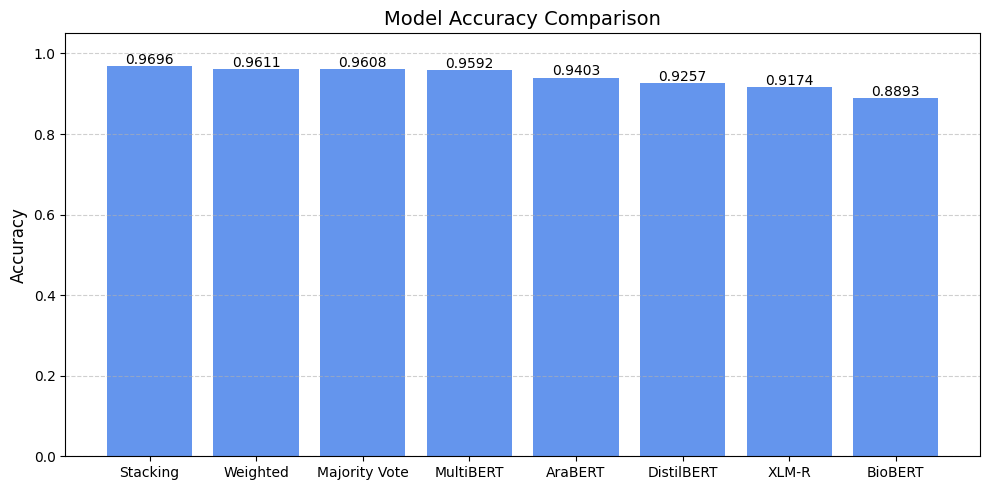

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/working/ensemble_with_stacking_results.csv")

method_map = {
    "bert-base-arabert-Severity_Prediction": "AraBERT",
    "BioBERT-Severity_Prediction": "BioBERT",
    "DistilBERT-Severity_Prediction": "DistilBERT",
    "bert-base-multilingual-cased-Severity_Prediction": "MultiBERT",
    "XLM-RoBERTa-Severity_Prediction": "XLM-R",
    "Ensemble_Prediction": "Majority Vote",
    "Weighted_Ensemble_Prediction": "Weighted",
    "Stacking_Ensemble_Prediction": "Stacking"
}

accuracies = [(label, (df["True_Severity"] == df[full]).mean()) for full, label in method_map.items()]

accuracies.sort(key=lambda x: x[1], reverse=True)

labels, values = zip(*accuracies)
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.4f}", ha='center', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("short_labels_accuracy_comparison.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import joblib

input_csv_path = "/kaggle/working/weighted_vote_results.csv"
meta_model_path = "/kaggle/working/meta_classifier.pkl"
output_csv_path = "/kaggle/working/ensemble_with_all_results.csv"

df = pd.read_csv(input_csv_path)

model_cols = [
    "bert-base-arabert-Severity_Prediction",
    "BioBERT-Severity_Prediction",
    "DistilBERT-Severity_Prediction",
    "bert-base-multilingual-cased-Severity_Prediction",
    "XLM-RoBERTa-Severity_Prediction"
]

def majority_vote(row):
    return row[model_cols].mode()[0]

df["Ensemble"] = df.apply(majority_vote, axis=1)
df["Ensemble_Correct"] = df["Ensemble"] == df["True_Severity"]

meta_model = joblib.load(meta_model_path)

all_labels = sorted(df["True_Severity"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

def extract_stacking_features(row):
    return [label_to_id[row[col]] for col in model_cols]

X_stacking = np.array(df.apply(extract_stacking_features, axis=1).tolist())

stacked_preds = meta_model.predict(X_stacking)
df["Stacking_Ensemble_Prediction"] = [id_to_label[p] for p in stacked_preds]
df["Stacking_Correct"] = df["Stacking_Ensemble_Prediction"] == df["True_Severity"]

df.to_csv(output_csv_path, index=False)

weighted_acc = df["Correct"].mean()
majority_acc = df["Ensemble_Correct"].mean()
stacking_acc = df["Stacking_Correct"].mean()

print(f"✅ Weighted Voting Accuracy: {weighted_acc:.4f}")
print(f"✅ Majority Voting (Ensemble) Accuracy: {majority_acc:.4f}")
print(f"✅ Stacking Ensemble Accuracy: {stacking_acc:.4f}")
print(f"\n📁 Results saved to: {output_csv_path}")

print("\n🔹 Prediction Sample:")
print(df[[
    "True_Severity",
    "Weighted_Ensemble_Prediction",
    "Ensemble",
    "Stacking_Ensemble_Prediction",
    "Correct",
    "Ensemble_Correct",
    "Stacking_Correct"
]].head())


✅ Weighted Voting Accuracy: 0.9611
✅ Majority Voting (Ensemble) Accuracy: 0.9553
✅ Stacking Ensemble Accuracy: 0.9696

📁 Results saved to: /kaggle/working/ensemble_with_all_results.csv

🔹 Prediction Sample:
  True_Severity Weighted_Ensemble_Prediction Ensemble  \
0       غير حرج                      غير حرج  غير حرج   
1       غير حرج                      غير حرج  غير حرج   
2       غير حرج                      غير حرج  غير حرج   
3           حرج                          حرج      حرج   
4       غير حرج                      غير حرج  غير حرج   

  Stacking_Ensemble_Prediction  Correct  Ensemble_Correct  Stacking_Correct  
0                      غير حرج     True              True              True  
1                      غير حرج     True              True              True  
2                          حرج     True              True             False  
3                          حرج     True              True              True  
4                      غير حرج     True              True   

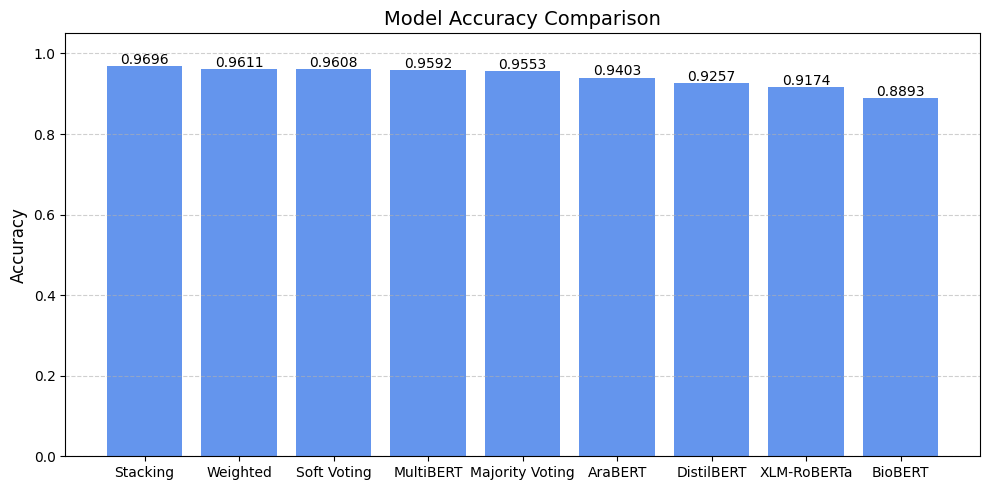

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/working/ensemble_with_all_results.csv")

method_map = {
    "bert-base-arabert-Severity_Prediction": "AraBERT",
    "BioBERT-Severity_Prediction": "BioBERT",
    "DistilBERT-Severity_Prediction": "DistilBERT",
    "bert-base-multilingual-cased-Severity_Prediction": "MultiBERT",
    "XLM-RoBERTa-Severity_Prediction": "XLM-RoBERTa",
    "Ensemble_Prediction": "Soft Voting",
    "Ensemble": "Majority Voting",
    "Weighted_Ensemble_Prediction": "Weighted",
    "Stacking_Ensemble_Prediction": "Stacking"
}

accuracies = [(label, (df["True_Severity"] == df[full]).mean()) for full, label in method_map.items()]

accuracies.sort(key=lambda x: x[1], reverse=True)

labels, values = zip(*accuracies)
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.4f}", ha='center', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("short_labels_accuracy_comparison.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import joblib

input_csv_path = "/kaggle/working/weighted_vote_results.csv"
meta_model_path = "/kaggle/working/meta_classifier.pkl"
output_csv_path = "/kaggle/working/ensemble_with_all_results.csv"

df = pd.read_csv(input_csv_path)

model_cols = [
    "bert-base-arabert-Severity_Prediction",
    "BioBERT-Severity_Prediction",
    "DistilBERT-Severity_Prediction",
    "bert-base-multilingual-cased-Severity_Prediction",
    "XLM-RoBERTa-Severity_Prediction"
]

def majority_vote(row):
    return row[model_cols].mode()[0]

df["Ensemble"] = df.apply(majority_vote, axis=1)
df["Ensemble_Correct"] = df["Ensemble"] == df["True_Severity"]

df["Weighted_Correct"] = df["Weighted_Ensemble_Prediction"] == df["True_Severity"]

meta_model = joblib.load(meta_model_path)

all_labels = sorted(df["True_Severity"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

def extract_stacking_features(row):
    return [label_to_id[row[col]] for col in model_cols]

X_stacking = np.array(df.apply(extract_stacking_features, axis=1).tolist())

stacked_preds = meta_model.predict(X_stacking)
df["Stacking_Ensemble_Prediction"] = [id_to_label[p] for p in stacked_preds]
df["Stacking_Correct"] = df["Stacking_Ensemble_Prediction"] == df["True_Severity"]

df.to_csv(output_csv_path, index=False)

weighted_acc = df["Weighted_Correct"].mean()
majority_acc = df["Ensemble_Correct"].mean()
stacking_acc = df["Stacking_Correct"].mean()

print(f"✅ Weighted Voting Accuracy: {weighted_acc:.4f}")
print(f"✅ Majority Voting (Ensemble) Accuracy: {majority_acc:.4f}")
print(f"✅ Stacking Ensemble Accuracy: {stacking_acc:.4f}")
print(f"\n📁 Results saved to: {output_csv_path}")

print("\n🔹 Prediction Sample:")
print(df[[
    "True_Severity",
    "Weighted_Ensemble_Prediction",
    "Ensemble",
    "Stacking_Ensemble_Prediction",
    "Weighted_Correct",
    "Ensemble_Correct",
    "Stacking_Correct"
]].head())


✅ Weighted Voting Accuracy: 0.9611
✅ Majority Voting (Ensemble) Accuracy: 0.9553
✅ Stacking Ensemble Accuracy: 0.9696

📁 Results saved to: /kaggle/working/ensemble_with_all_results.csv

🔹 Prediction Sample:
  True_Severity Weighted_Ensemble_Prediction Ensemble  \
0       غير حرج                      غير حرج  غير حرج   
1       غير حرج                      غير حرج  غير حرج   
2       غير حرج                      غير حرج  غير حرج   
3           حرج                          حرج      حرج   
4       غير حرج                      غير حرج  غير حرج   

  Stacking_Ensemble_Prediction  Weighted_Correct  Ensemble_Correct  \
0                      غير حرج              True              True   
1                      غير حرج              True              True   
2                          حرج              True              True   
3                          حرج              True              True   
4                      غير حرج              True              True   

   Stacking_Correct  
0      

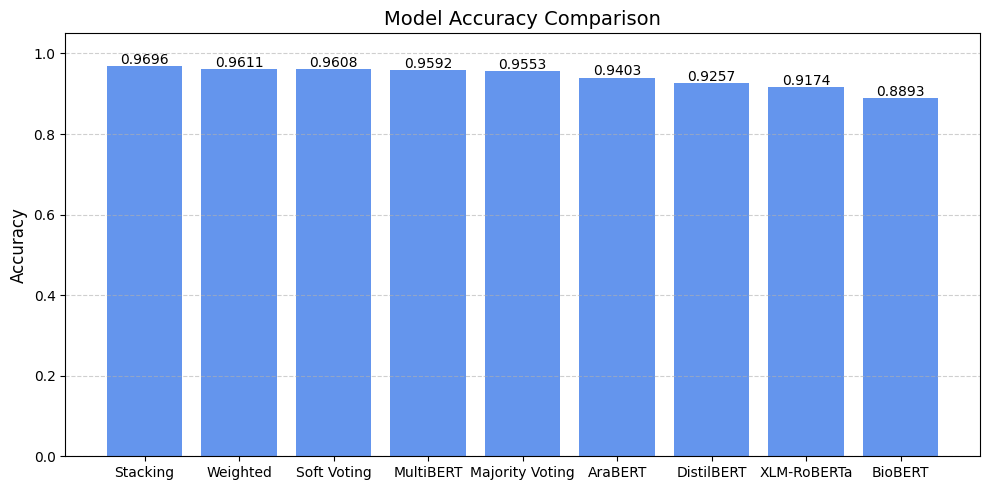

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/newwdata/ensemble_with_all_results (1).csv")

method_map = {
    "bert-base-arabert-Severity_Prediction": "AraBERT",
    "BioBERT-Severity_Prediction": "BioBERT",
    "DistilBERT-Severity_Prediction": "DistilBERT",
    "bert-base-multilingual-cased-Severity_Prediction": "MultiBERT",
    "XLM-RoBERTa-Severity_Prediction": "XLM-RoBERTa",
    "Soft_Voting": "Soft Voting",
    "Majority_Voting": "Majority Voting",
    "Weighted_Voting": "Weighted",
    "Stacking_Ensemble_Prediction": "Stacking"
}

accuracies = [(label, (df["True_Severity"] == df[full]).mean()) for full, label in method_map.items()]

accuracies.sort(key=lambda x: x[1], reverse=True)

labels, values = zip(*accuracies)
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.4f}", ha='center', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("short_labels_accuracy_comparison.png", dpi=300)
plt.show()


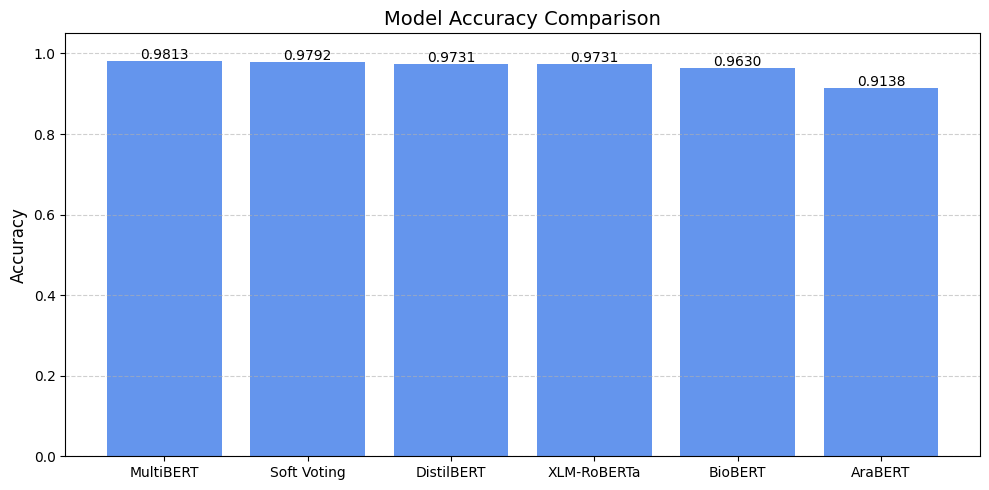

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results
df = pd.read_csv("/kaggle/input/typeee/ensemble_individual_prediction.csv")

method_map = {
    "AraBert_Prediction": "AraBERT",
    "BioBert (2)_Prediction": "BioBERT",
    "distilBert_Prediction": "DistilBERT",
    "multiBert_Prediction": "MultiBERT",
    "xlmRoBERTaa_Prediction": "XLM-RoBERTa",
    "Ensemble_Prediction": "Soft Voting",
}

accuracies = [(label, (df["True_Category"] == df[full]).mean()) for full, label in method_map.items()]

accuracies.sort(key=lambda x: x[1], reverse=True)

labels, values = zip(*accuracies)
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.4f}", ha='center', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("short_labels_accuracy_comparison.png", dpi=300)
plt.show()


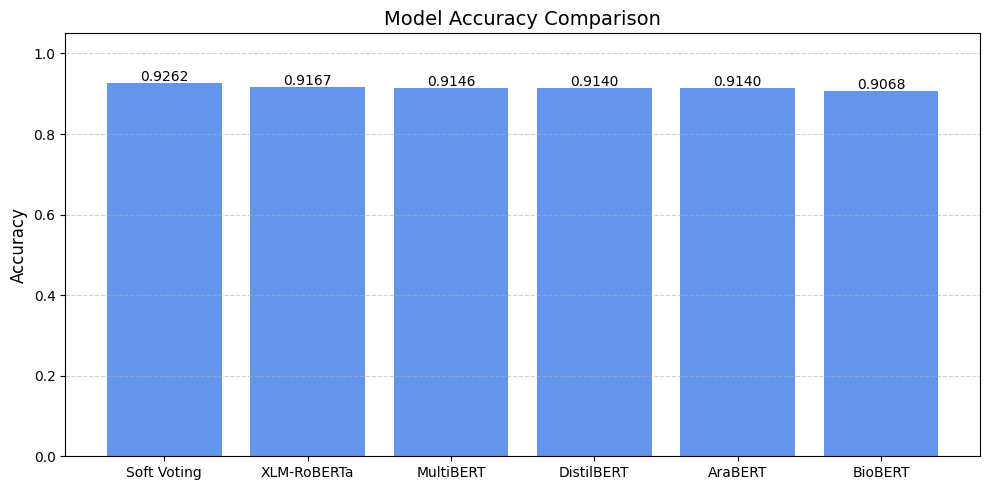

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/typeeee/ensemble_individual_prediction (2).csv")

method_map = {
    "AraBert_Prediction": "AraBERT",
    "BioBert (2)_Prediction": "BioBERT",
    "distilBert_Prediction": "DistilBERT",
    "multiBert_Prediction": "MultiBERT",
    "xlmRoBERTaa_Prediction": "XLM-RoBERTa",
    "Ensemble_Prediction": "Soft Voting",
}

accuracies = [(label, (df["True_Category"] == df[full]).mean()) for full, label in method_map.items()]

accuracies.sort(key=lambda x: x[1], reverse=True)

labels, values = zip(*accuracies)
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='cornflowerblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.4f}", ha='center', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("short_labels_accuracy_comparison.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression

csv_path = "/kaggle/input/typeeee/ensemble_individual_prediction (2).csv"
df = pd.read_csv(csv_path)
print(f"✅ Loaded {len(df)} samples from: {csv_path}")

model_cols = [
    "AraBert_Prediction",
    "BioBert (2)_Prediction",
    "distilBert_Prediction",
    "multiBert_Prediction",
    "xlmRoBERTaa_Prediction"
]

all_labels = sorted(df["True_Category"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

for col in model_cols:
    df[col + "_id"] = df[col].map(label_to_id)
df["True_Category_id"] = df["True_Category"].map(label_to_id)

X = df[[col + "_id" for col in model_cols]].values
y = df["True_Category_id"].values

print("🔄 Training meta-classifier (LogisticRegression)...")
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X, y)

output_path = "/kaggle/working/metaa_classifier.pkl"
joblib.dump(meta_model, output_path)
print(f"\n✅ Meta-classifier saved to: {output_path}")


✅ Loaded 39789 samples from: /kaggle/input/typeeee/ensemble_individual_prediction (2).csv
🔄 Training meta-classifier (LogisticRegression)...

✅ Meta-classifier saved to: /kaggle/working/metaa_classifier.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pandas as pd
import numpy as np
import joblib

input_csv_path = "/kaggle/input/typeeee/ensemble_individual_prediction (2).csv"
meta_model_path = "/kaggle/working/metaa_classifier.pkl"
output_csv_path = "/kaggle/working/ensemble_methods_types.csv"

print(f"🔹 Loading input CSV from: {input_csv_path}")
df = pd.read_csv(input_csv_path)
print(f"✅ Loaded {len(df)} samples")

model_cols = [
    "AraBert_Prediction",
    "BioBert (2)_Prediction",
    "distilBert_Prediction",
    "multiBert_Prediction",
    "xlmRoBERTaa_Prediction"
]

weights = {
    "AraBert_Prediction": 0.3,
    "BioBert (2)_Prediction": 0.25,
    "distilBert_Prediction": 0.15,
    "multiBert_Prediction": 0.2,
    "xlmRoBERTaa_Prediction": 0.1
}

def weighted_vote(row):
    score_map = {}
    for col in model_cols:
        pred = row[col]
        score_map[pred] = score_map.get(pred, 0) + weights[col]
    return max(score_map, key=score_map.get)

print("🔹 Applying Weighted Voting...")
df["Weighted_Ensemble_Prediction"] = df.apply(weighted_vote, axis=1)
df["Weighted_Correct"] = df["Weighted_Ensemble_Prediction"] == df["True_Category"]

all_labels = sorted(df["True_Category"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

def extract_stacking_features(row):
    return [label_to_id[row[col]] for col in model_cols]

X_stacking = np.array(df.apply(extract_stacking_features, axis=1).tolist())

print(f"🔹 Loading meta-classifier from: {meta_model_path}")
meta_model = joblib.load(meta_model_path)

stacked_preds = meta_model.predict(X_stacking)
df["Stacking_Ensemble_Prediction"] = [id_to_label[p] for p in stacked_preds]
df["Stacking_Correct"] = df["Stacking_Ensemble_Prediction"] == df["True_Category"]

df["Majority_Correct"] = df["Ensemble_Prediction"] == df["True_Category"]

df.to_csv(output_csv_path, index=False)

print("\n📊 Ensemble Accuracies:")
print(f"✅ Weighted Voting Accuracy : {df['Weighted_Correct'].mean():.4f}")
print(f"✅ Majority Voting Accuracy : {df['Majority_Correct'].mean():.4f}")
print(f"✅ Stacking Accuracy         : {df['Stacking_Correct'].mean():.4f}")
print(f"\n📁 Results saved to: {output_csv_path}")

print("\n🔹 Sample Output:")
print(df[[
    "True_Category",
    "AraBert_Prediction",
    "BioBert (2)_Prediction",
    "distilBert_Prediction",
    "multiBert_Prediction",
    "xlmRoBERTaa_Prediction",
    "Ensemble_Prediction",
    "Weighted_Ensemble_Prediction",
    "Stacking_Ensemble_Prediction"
]].head())


🔹 Loading input CSV from: /kaggle/input/typeeee/ensemble_individual_prediction (2).csv
✅ Loaded 39789 samples
🔹 Applying Weighted Voting...
🔹 Loading meta-classifier from: /kaggle/working/metaa_classifier.pkl

📊 Ensemble Accuracies:
✅ Weighted Voting Accuracy : 0.9242
✅ Majority Voting Accuracy : 0.9262
✅ Stacking Accuracy         : 0.7587

📁 Results saved to: /kaggle/working/ensemble_methods_types.csv

🔹 Sample Output:
            True_Category      AraBert_Prediction  BioBert (2)_Prediction  \
0              امراض الدم              امراض الدم              امراض الدم   
1          انف اذن وحنجرة          انف اذن وحنجرة          انف اذن وحنجرة   
2  امراض القلب و الشرايين  امراض القلب و الشرايين  امراض القلب و الشرايين   
3          انف اذن وحنجرة          انف اذن وحنجرة          انف اذن وحنجرة   
4     امراض الجهاز الهضمي     امراض الجهاز الهضمي     امراض الجهاز الهضمي   

    distilBert_Prediction    multiBert_Prediction  xlmRoBERTaa_Prediction  \
0  امراض القلب و الشرايين           

In [ ]:
import pandas as pd
import numpy as np
import joblib

input_csv_path = "/kaggle/input/typeeee/ensemble_individual_prediction (2).csv"
meta_model_path = "/kaggle/working/metaa_classifier.pkl"
output_csv_path = "/kaggle/working/final_ensemble_results.csv"

print(f"🔹 Loading input CSV from: {input_csv_path}")
df = pd.read_csv(input_csv_path)
print(f"✅ Loaded {len(df)} samples\n")

model_cols = [
    "AraBert_Prediction",
    "BioBert (2)_Prediction",
    "distilBert_Prediction",
    "multiBert_Prediction",
    "xlmRoBERTaa_Prediction"
]

weights = {
    "AraBert_Prediction": 0.3,
    "BioBert (2)_Prediction": 0.25,
    "distilBert_Prediction": 0.15,
    "multiBert_Prediction": 0.2,
    "xlmRoBERTaa_Prediction": 0.1
}

def weighted_vote(row):
    score_map = {}
    for col in model_cols:
        pred = row[col]
        score_map[pred] = score_map.get(pred, 0) + weights[col]
    return max(score_map, key=score_map.get)

print("🔹 Applying Weighted Voting...")
df["Weighted_Ensemble_Prediction"] = df.apply(weighted_vote, axis=1)
df["Weighted_Correct"] = df["Weighted_Ensemble_Prediction"] == df["True_Category"]


print("🔹 Applying Majority Voting...")
df["Majority_Correct"] = df["Ensemble_Prediction"] == df["True_Category"]

all_labels = sorted(df["True_Category"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

def extract_stacking_features(row):
    return [label_to_id[row[col]] for col in model_cols]

X_stacking = np.array(df.apply(extract_stacking_features, axis=1).tolist())

print(f"🔹 Loading Stacking Meta-Model from: {meta_model_path}")
meta_model = joblib.load(meta_model_path)

print("🔹 Predicting with Stacking Meta-Model...")
stacked_preds = meta_model.predict(X_stacking)
df["Stacking_Ensemble_Prediction"] = [id_to_label[p] for p in stacked_preds]
df["Stacking_Correct"] = df["Stacking_Ensemble_Prediction"] == df["True_Category"]

weighted_acc = df["Weighted_Correct"].mean()
majority_acc = df["Majority_Correct"].mean()
stacking_acc = df["Stacking_Correct"].mean()

df.to_csv(output_csv_path, index=False)

print("\n📊 Ensemble Accuracy Results:")
print(f"📌 Weighted Voting Accuracy : {weighted_acc:.4f}")
print(f"📌 Majority Voting Accuracy : {majority_acc:.4f}")
print(f"📌 Stacking Ensemble Accuracy: {stacking_acc:.4f}")

best_method = max(
    [("Weighted Voting", weighted_acc),
     ("Majority Voting", majority_acc),
     ("Stacking", stacking_acc)],
    key=lambda x: x[1]
)
print(f"\n🏆 Best Performing Method: {best_method[0]} with accuracy {best_method[1]:.4f}")

print("\n🔹 Sample Predictions:")
print(df[[
    "True_Category",
    "AraBert_Prediction",
    "BioBert (2)_Prediction",
    "distilBert_Prediction",
    "multiBert_Prediction",
    "xlmRoBERTaa_Prediction",
    "Ensemble_Prediction",
    "Weighted_Ensemble_Prediction",
    "Stacking_Ensemble_Prediction"
]].head())

print(f"\n📁 Full results saved to: {output_csv_path}")


🔹 Loading input CSV from: /kaggle/input/typeeee/ensemble_individual_prediction (2).csv
✅ Loaded 39789 samples

🔹 Applying Weighted Voting...
🔹 Applying Majority Voting...
🔹 Loading Stacking Meta-Model from: /kaggle/working/metaa_classifier.pkl
🔹 Predicting with Stacking Meta-Model...

📊 Ensemble Accuracy Results:
📌 Weighted Voting Accuracy : 0.9242
📌 Majority Voting Accuracy : 0.9262
📌 Stacking Ensemble Accuracy: 0.7587

🏆 Best Performing Method: Majority Voting with accuracy 0.9262

🔹 Sample Predictions:
            True_Category      AraBert_Prediction  BioBert (2)_Prediction  \
0              امراض الدم              امراض الدم              امراض الدم   
1          انف اذن وحنجرة          انف اذن وحنجرة          انف اذن وحنجرة   
2  امراض القلب و الشرايين  امراض القلب و الشرايين  امراض القلب و الشرايين   
3          انف اذن وحنجرة          انف اذن وحنجرة          انف اذن وحنجرة   
4     امراض الجهاز الهضمي     امراض الجهاز الهضمي     امراض الجهاز الهضمي   

    distilBert_Prediction 

🔹 Loading input CSV from: /kaggle/input/typeeee/ensemble_individual_prediction (2).csv
✅ Loaded 39789 samples

🔹 Applying Majority Voting...
🔹 Applying Weighted Voting...
🔹 Loading meta-classifier from: /kaggle/working/metaa_classifier.pkl
🔹 Predicting using Stacking...

📊 Accuracy Summary:
Majority Voting     : 0.9256
Weighted Voting     : 0.9242
xlmRoBERTaa         : 0.9167
multiBert           : 0.9146
distilBert          : 0.9140
AraBert             : 0.9140
BioBert (2)         : 0.9068
Stacking            : 0.7587


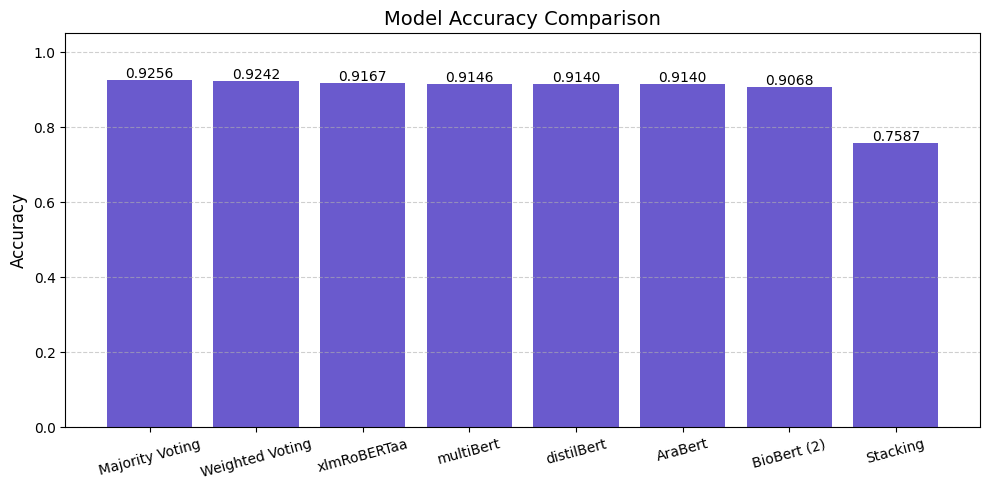


✅ All predictions and metrics saved to: /kaggle/working/final_ensemble_types.csv


In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

input_csv_path = "/kaggle/input/typeeee/ensemble_individual_prediction (2).csv"
meta_model_path = "/kaggle/working/metaa_classifier.pkl"
output_csv_path = "/kaggle/working/final_ensemble_types.csv"

print(f"🔹 Loading input CSV from: {input_csv_path}")
df = pd.read_csv(input_csv_path)
print(f"✅ Loaded {len(df)} samples\n")

model_cols = [
    "AraBert_Prediction",
    "BioBert (2)_Prediction",
    "distilBert_Prediction",
    "multiBert_Prediction",
    "xlmRoBERTaa_Prediction"
]

weights = {
    "AraBert_Prediction": 0.2,
    "BioBert (2)_Prediction": 0.1,
    "distilBert_Prediction": 0.15,
    "multiBert_Prediction": 0.25,
    "xlmRoBERTaa_Prediction": 0.3
}

def majority_vote(row):
    return row[model_cols].mode()[0]

print("🔹 Applying Majority Voting...")
df["Majority_Ensemble_Prediction"] = df.apply(majority_vote, axis=1)
df["Majority_Correct"] = df["Majority_Ensemble_Prediction"] == df["True_Category"]

def weighted_vote(row):
    score_map = {}
    for col in model_cols:
        pred = row[col]
        score_map[pred] = score_map.get(pred, 0) + weights[col]
    return max(score_map, key=score_map.get)

print("🔹 Applying Weighted Voting...")
df["Weighted_Ensemble_Prediction"] = df.apply(weighted_vote, axis=1)
df["Weighted_Correct"] = df["Weighted_Ensemble_Prediction"] == df["True_Category"]

all_labels = sorted(df["True_Category"].unique())
label_to_id = {label: i for i, label in enumerate(all_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

def extract_stacking_features(row):
    return [label_to_id[row[col]] for col in model_cols]

X_stacking = np.array(df.apply(extract_stacking_features, axis=1).tolist())

print(f"🔹 Loading meta-classifier from: {meta_model_path}")
meta_model = joblib.load(meta_model_path)

print("🔹 Predicting using Stacking...")
stacked_preds = meta_model.predict(X_stacking)
df["Stacking_Ensemble_Prediction"] = [id_to_label[p] for p in stacked_preds]
df["Stacking_Correct"] = df["Stacking_Ensemble_Prediction"] == df["True_Category"]

results = []

for col in model_cols:
    acc = (df[col] == df["True_Category"]).mean()
    results.append((col.replace("_Prediction", ""), acc))

results.append(("Majority Voting", df["Majority_Correct"].mean()))
results.append(("Weighted Voting", df["Weighted_Correct"].mean()))
results.append(("Stacking", df["Stacking_Correct"].mean()))

results.sort(key=lambda x: x[1], reverse=True)

print("\n📊 Accuracy Summary:")
for name, acc in results:
    print(f"{name:<20}: {acc:.4f}")

labels, values = zip(*results)
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='slateblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.4f}", ha='center')

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=15)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("ensemble_accuracy_comparison.png", dpi=300)
plt.show()

df.to_csv(output_csv_path, index=False)
print(f"\n✅ All predictions and metrics saved to: {output_csv_path}")


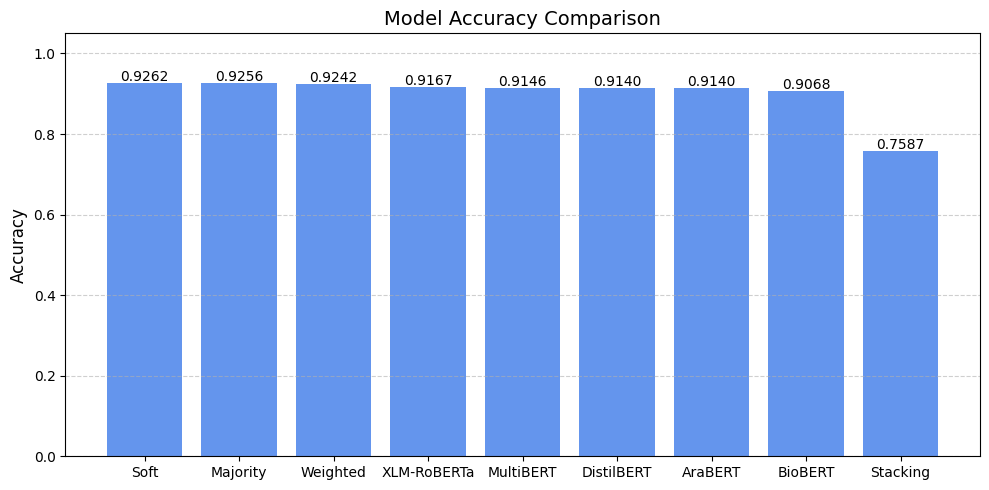

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/ensemble-types/final_ensemble_types.csv")

method_map = {
    "AraBert_Prediction": "AraBERT",
    "BioBert (2)_Prediction": "BioBERT",
    "distilBert_Prediction": "DistilBERT",
    "multiBert_Prediction": "MultiBERT",
    "xlmRoBERTaa_Prediction": "XLM-RoBERTa",
    "Soft_Voting": "Soft",
    "Majority_Voting": "Majority",
    "Weighted_Voting": "Weighted",
    "Stacking_Ensemble_Prediction": "Stacking"
}

accuracies = [(label, (df["True_Category"] == df[full]).mean()) for full, label in method_map.items()]

accuracies.sort(key=lambda x: x[1], reverse=True)

# Plot
labels, values = zip(*accuracies)
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color='cornflowerblue')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.4f}", ha='center', fontsize=10)

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("short_labels_accuracy_comparison.png", dpi=300)
plt.show()
